# Predicting the number of bikes rented per hour

In this project, we use a few simple machine-learning models (linear regression, decision tree, and random forest) to predict te number of bikes rented by the hour in Washington, D.C.. 
Like many other American cities, Washington, D.C. has a communal bike-renting service. 
Bikes can be rented for eiteher one hour or one day. 

One important problem for cities setting or and maintaning similar services is to estimate how many bicycles are needed and where, to ensure the number of bikes on offer is high enough to cover the residents' needs while avoiding the extra costs and space obstruction of keeping more bikes than necessary. 
We here deal with the first question, and aim at predicting the number of bikes rented per hour. 

## The Dataset

We will work with a dataset containing the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system from the [UC Irvine Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). 
It was compiled by Hadi Fanaee from the Laboratory of Artificial Intelligence and Decision Support (LIAAD), University of Porto . 

We first import the packages we will need: 

In [38]:
# Pandas to work with the dataset
import pandas as pd

# Numpy for numeric calculations
import numpy as np

# Pyplot for plots
import matplotlib.pyplot as plt

# Linear regression model
from sklearn.linear_model import LinearRegression

# Decision tree
from sklearn.tree import DecisionTreeRegressor

# Random forest
from sklearn.ensemble import RandomForestRegressor

# Mean squared error
from sklearn.metrics import mean_squared_error

Load the dataset and print the first few rows: 

In [2]:
bike_rentals = pd.read_csv('../Data/Bike-Sharing-Dataset/hour.csv')
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Let us see whether there are missing values: 

In [3]:
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


It seems there is no missing value. 

In principle, the `cnt` column, giving the total number of rentals, should be the sum of the `casual` and `registered` ones. 
Let us check this: 

In [4]:
(bike_rentals['cnt'] == bike_rentals['casual'] + bike_rentals['registered']).value_counts()

True    17379
dtype: int64

This is indeed the case. 
The dataset thus seems consistent in this regard. 

Our target variable will be the `cst` column, giving the total number of rentals for each hour. 
Let us plot a histogram to get a glimpse of its distribution: 

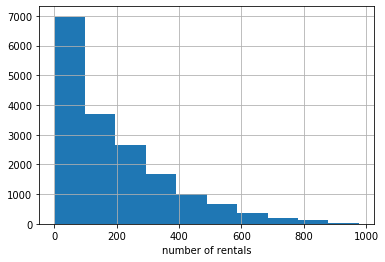

In [5]:
bike_rentals['cnt'].hist()
plt.xlabel('number of rentals')
plt.show()

The distribution seems to be monotonically decreasing, with numbers smaller than 100 for nearly half of the rows. 

Let us now see how the other numeric coluns are correlated with `cnt`: 

In [6]:
bike_rentals.corr()['cnt'].sort_values(ascending=False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

The two columns `registered` and `casual` are strongly correlated with `cnt`. 
This is not surprising as the later is the sum of the former two. 
The corelation is significantly stronger for the `registered` column, which indicates that registered users account for most rentals.

The next variables showing strongest correlation with `cnt` are the temperature (`temp`) and felt temperature (`atemp`), closely followed by the hour (`hr`). 
The humidity (`hum`) also has a significant  negative correlation.

We can not use the `registered` and `casual` columns to make predictions as they are part of what we want to predict. 
It thus seems that the most relevent factors to focus on are the temperature, felt temperature, and humidity.

Let us see whether they are correlated to each others:

In [7]:
cols = ['temp', 'atemp', 'hr', 'hum']
bike_rentals[cols].corr()

,temp,atemp,hr,hum
temp,1.000000,0.987672,0.137603,-0.069881
atemp,0.987672,1.000000,0.133750,-0.051918
hr,0.137603,0.133750,1.000000,-0.276498
hum,-0.069881,-0.051918,-0.276498,1.000000


There is a very strong correlation (close to 0.988) between the temperature and felt temperature. 
It may thus be relevent to include only one of these two columns as they contain essenntially the same information.

## Feature engineering

### Time of the day

Let us first divide the day into 4 equal periods: morning from 6:00 to 11:59, afternoon from 12:00 to 17:59, evening from 18:00 to 23:59, and night from 0:00 to 5:59, associated respectively with the labels 1, 2, 3, and 4. 
We wall this column `time_label`.

In [8]:
def label_hour(hr):
    '''
    labels the hour hr with 1 (morning), 2 (afternoon), 3 (evening), or 4 
    (night)
    
    hr: integer between 0 and 23 (included)
    '''
    if hr < 6:
        return 4
    if hr < 12:
        return 1
    if hr < 18:
        return 2
    return 3

bike_rentals['time_label'] = bike_rentals['hr'].apply(label_hour)
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,4


### Dropping ununcessary columns

The column `instant` serves an an index, and does not contain any actual information. 
We will also not make use of the `dteday`, `registered`, `casual`, and `atemp` columns.
Let us drop them:

In [9]:
bike_rentals = bike_rentals.drop(['instant', 'dteday', 'registered', 'casual', 'atemp'], axis=1)
bike_rentals.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,time_label
0,1,0,1,0,0,6,0,1,0.24,0.81,0.0,16,4
1,1,0,1,1,0,6,0,1,0.22,0.80,0.0,40,4
2,1,0,1,2,0,6,0,1,0.22,0.80,0.0,32,4
3,1,0,1,3,0,6,0,1,0.24,0.75,0.0,13,4
4,1,0,1,4,0,6,0,1,0.24,0.75,0.0,1,4


## Separation into training and validation sets

We now divide the dataset into a training set `train` with about 80% of the data and a validation set `test` with the remaining data. 
The performance of the models will be estimated using the mean squared error. 

In [10]:
# we set a random state to make the results reproducible
train = bike_rentals.sample(frac = 0.8, random_state = 25)
test = bike_rentals[~bike_rentals.index.isin(train.index)]

display(train.head())
display(test.head())

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,time_label
3555,2,0,6,1,0,4,1,1,0.72,0.38,0.1045,15,4
16834,4,1,12,5,0,0,0,2,0.40,0.87,0.1045,8,4
6971,4,0,10,2,0,0,0,1,0.34,0.87,0.0896,50,4
5165,3,0,8,3,0,1,1,1,0.66,0.89,0.0000,1,4
8913,1,1,1,6,0,4,1,3,0.36,0.93,0.1343,89,1


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,time_label
8,1,0,1,8,0,6,0,1,0.24,0.75,0.0000,8,1
14,1,0,1,14,0,6,0,2,0.46,0.72,0.2836,106,2
17,1,0,1,17,0,6,0,2,0.44,0.82,0.2836,67,2
23,1,0,1,23,0,6,0,2,0.46,0.88,0.2985,39,3
25,1,0,1,1,0,0,0,2,0.44,0.94,0.2537,17,4


## Linear Regression

The first model we will use is a linear regression. 
We shall build four models with a different number of features.

### Two features

We first build a model with two features only. 
To select them, let us see which ones are strongly correlated with the rarget:

In [11]:
target = 'cnt'

abs(bike_rentals.corr()[target]).sort_values(ascending=False)

cnt           1.000000
temp          0.404772
hr            0.394071
time_label    0.378318
hum           0.322911
yr            0.250495
season        0.178056
weathersit    0.142426
mnth          0.120638
windspeed     0.093234
holiday       0.030927
workingday    0.030284
weekday       0.026900
Name: cnt, dtype: float64

The four columns showing strongest correlations with the target are `temp`, `hr`, `time_label`, and `hum`. 
Let us see how correlated they are with each others:

In [12]:
cols = ['temp', 'hr', 'time_label', 'hum']
bike_rentals[cols].corr()

,temp,hr,time_label,hum
temp,1.000000,0.137603,-0.061551,-0.069881
hr,0.137603,1.000000,-0.187486,-0.276498
time_label,-0.061551,-0.187486,1.000000,0.144593
hum,-0.069881,-0.276498,0.144593,1.000000


They do not seem to be strongly correlated with each others. 

In [13]:
features = ['temp', 'hr']

lr1 = LinearRegression()
lr1.fit(train[features], train[target])

predictions = lr1.predict(test[features])
rmse = np.sqrt(mean_squared_error(predictions, test[target]))
relat_rmse = rmse / test[target].std()

print('rmse / std = ' + str(relat_rmse))
print('Correlation coefficient: ' + str(test[target].reset_index(drop=True).corr(pd.Series(predictions))))

rmse / std = 0.8360627576110233
Correlation coefficient: 0.548700907174461


The root mean squared error is about 84% of the test data standard error, and the correlation coefficient between the prediction and actual values is just below 0.55. 
Our model is thus not very accurate, although it is predicting something.

### Four features

Let ud now try adding the features `time_label` and `hum`.

In [14]:
features = ['temp', 'hr', 'time_label', 'hum']

lr2 = LinearRegression()
lr2.fit(train[features], train[target])

predictions = lr2.predict(test[features])
rmse = np.sqrt(mean_squared_error(predictions, test[target]))
relat_rmse = rmse / test[target].std()

print('rmse / std = ' + str(relat_rmse))
print('Correlation coefficient: ' + str(test[target].reset_index(drop=True).corr(pd.Series(predictions))))

rmse / std = 0.7679587887826516
Correlation coefficient: 0.6404048748629122


This model is a little bit more accurate than the previous one.

### Six features

Let us add the `yr` and `season` columns:

In [15]:
features = ['temp', 'hr', 'time_label', 'hum', 'yr', 'season']

lr4 = LinearRegression()
lr4.fit(train[features], train[target])

predictions = lr4.predict(test[features])
rmse = np.sqrt(mean_squared_error(predictions, test[target]))
relat_rmse = rmse / test[target].std()

print('rmse / std = ' + str(relat_rmse))
print('Correlation coefficient: ' + str(test[target].reset_index(drop=True).corr(pd.Series(predictions))))

rmse / std = 0.7300569849225247
Correlation coefficient: 0.683378384192659


This model performs a bit better than the previous one. 

### All features

Let us now use all features:

In [16]:
features = ['temp', 'hr', 'time_label', 'hum', 'yr', 'season', 'weathersit', 'mnth', 'windspeed', 'holiday', 'workingday', 'weekday']

lr4 = LinearRegression()
lr4.fit(train[features], train[target])

predictions = lr4.predict(test[features])
rmse = np.sqrt(mean_squared_error(predictions, test[target]))
relat_rmse = rmse / test[target].std()

print('rmse / std = ' + str(relat_rmse))
print('Correlation coefficient: ' + str(test[target].reset_index(drop=True).corr(pd.Series(predictions))))

rmse / std = 0.7285471221750136
Correlation coefficient: 0.6850000447693583


This model performs slightly better than the one with four features and very slightly worse than that with six features (but the difference may not be statistically significant).

## Decision tree

Let us now train a decision tree on the same data, with the same features as above.

### Two features

In [20]:
features = ['temp', 'hr']

dt1 = DecisionTreeRegressor()
dt1.fit(train[features], train[target])

predictions = dt1.predict(test[features])
rmse = np.sqrt(mean_squared_error(predictions, test[target]))
relat_rmse = rmse / test[target].std()

print('rmse / std = ' + str(relat_rmse))
print('Correlation coefficient: ' + str(test[target].reset_index(drop=True).corr(pd.Series(predictions))))

rmse / std = 0.6050216411159434
Correlation coefficient: 0.7969085584906862


This is already better than all the linear regression models we tried.

### Four features

In [21]:
features = ['temp', 'hr', 'time_label', 'hum']

dt2 = DecisionTreeRegressor()
dt2.fit(train[features], train[target])

predictions = dt2.predict(test[features])
rmse = np.sqrt(mean_squared_error(predictions, test[target]))
relat_rmse = rmse / test[target].std()

print('rmse / std = ' + str(relat_rmse))
print('Correlation coefficient: ' + str(test[target].reset_index(drop=True).corr(pd.Series(predictions))))

rmse / std = 0.7279297447600013
Correlation coefficient: 0.7290579211127172


Results are slightly worse than those obtained with two features only.

### Six features

In [22]:
features = ['temp', 'hr', 'time_label', 'hum', 'yr', 'season']

dt3 = DecisionTreeRegressor()
dt3.fit(train[features], train[target])

predictions = dt3.predict(test[features])
rmse = np.sqrt(mean_squared_error(predictions, test[target]))
relat_rmse = rmse / test[target].std()

print('rmse / std = ' + str(relat_rmse))
print('Correlation coefficient: ' + str(test[target].reset_index(drop=True).corr(pd.Series(predictions))))

rmse / std = 0.6312682441774711
Correlation coefficient: 0.8020898883849062


These results are close to those obtained with two features, and better than those obtained with four.

### All features

In [23]:
features = ['temp', 'hr', 'time_label', 'hum', 'yr', 'season', 'weathersit', 'mnth', 'windspeed', 'holiday', 'workingday', 'weekday']

dt4 = DecisionTreeRegressor()
dt4.fit(train[features], train[target])

predictions = dt4.predict(test[features])
rmse = np.sqrt(mean_squared_error(predictions, test[target]))
relat_rmse = rmse / test[target].std()

print('rmse / std = ' + str(relat_rmse))
print('Correlation coefficient: ' + str(test[target].reset_index(drop=True).corr(pd.Series(predictions))))

rmse / std = 0.31718225120695914
Correlation coefficient: 0.9494605246389439


A classification tree trained with all features gives significantly better results than other decision trees as well as the linear models. 
The correlation coefficient between the predictions and actual values in the validation set is close to 0.95, and the root mean squared error is only slightly above 32% of the standard deviation.

Let us see if we can improve the results by changing the `min_samples_leaf` and `max_depth` parameters. 

,1,3,9,27,81,243
2,0.763632,0.763632,0.763632,0.763632,0.763632,0.763632
6,0.544955,0.544952,0.544947,0.544936,0.548840,0.557716
18,0.319017,0.300818,0.301207,0.321996,0.388717,0.528185
56,0.318842,0.301634,0.301213,0.321996,0.388717,0.528185
168,0.319664,0.299684,0.301037,0.321996,0.388717,0.528185
504,0.319235,0.299632,0.301087,0.321996,0.388717,0.528185


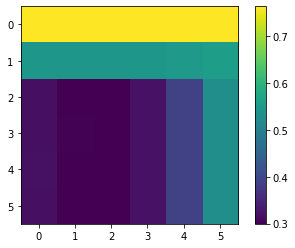

In [60]:
list_max_depth = [2, 6, 18, 56, 168, 504]
list_min_samples_leaf = [1, 3, 9, 27, 81, 243]
res = []
for max_depth in list_max_depth:
    res.append([])
    for min_samples_leaf in list_min_samples_leaf:
        dt = DecisionTreeRegressor(max_depth = max_depth, min_samples_leaf = min_samples_leaf)
        dt.fit(train[features], train[target])
        predictions = dt.predict(test[features])
        rmse = np.sqrt(mean_squared_error(predictions, test[target]))
        relat_rmse = rmse / test[target].std()
        res[-1].append(relat_rmse)
        
display(pd.DataFrame(res, columns=list_min_samples_leaf, index=list_max_depth))

plt.imshow(res)
plt.colorbar()
plt.show()

The best parameters have a low value for `min_samples_leaf` and a relatively high value for `max_depth`. 
The performance is thenclose to the default one.

## Random forest

Finally, let us train a random forest classifier. 

### Two features

In [39]:
features = ['temp', 'hr']

rf1 = RandomForestRegressor()
rf1.fit(train[features], train[target])

predictions = rf1.predict(test[features])
rmse = np.sqrt(mean_squared_error(predictions, test[target]))
relat_rmse = rmse / test[target].std()

print('rmse / std = ' + str(relat_rmse))
print('Correlation coefficient: ' + str(test[target].reset_index(drop=True).corr(pd.Series(predictions))))

rmse / std = 0.6046177338627762
Correlation coefficient: 0.7972360349598944


Results are close to those obtained with a single tree.

This is already better than all the linear regression models we tried.

### Four features

In [40]:
features = ['temp', 'hr', 'time_label', 'hum']

rf2 = RandomForestRegressor()
rf2.fit(train[features], train[target])

predictions = rf2.predict(test[features])
rmse = np.sqrt(mean_squared_error(predictions, test[target]))
relat_rmse = rmse / test[target].std()

print('rmse / std = ' + str(relat_rmse))
print('Correlation coefficient: ' + str(test[target].reset_index(drop=True).corr(pd.Series(predictions))))

rmse / std = 0.6323355324517869
Correlation coefficient: 0.7844176141814561


Results are close to those obtained with two or four features.

### Six features

In [42]:
features = ['temp', 'hr', 'time_label', 'hum', 'yr', 'season']

rf3 = RandomForestRegressor()
rf3.fit(train[features], train[target])

predictions = dt3.predict(test[features])
rmse = np.sqrt(mean_squared_error(predictions, test[target]))
relat_rmse = rmse / test[target].std()

print('rmse / std = ' + str(relat_rmse))
print('Correlation coefficient: ' + str(test[target].reset_index(drop=True).corr(pd.Series(predictions))))

rmse / std = 0.6312682441774711
Correlation coefficient: 0.8020898883849062


These results are close to those obtained with two features, and better than those obtained with four.

### All features

In [46]:
features = ['temp', 'hr', 'time_label', 'hum', 'yr', 'season', 'weathersit', 'mnth', 'windspeed', 'holiday', 'workingday', 'weekday']

rf4 = RandomForestRegressor()
rf4.fit(train[features], train[target])

predictions = rf4.predict(test[features])
rmse = np.sqrt(mean_squared_error(predictions, test[target]))
relat_rmse = rmse / test[target].std()

print('rmse / std = ' + str(relat_rmse))
print('Correlation coefficient: ' + str(test[target].reset_index(drop=True).corr(pd.Series(predictions))))

rmse / std = 0.23443032893508098
Correlation coefficient: 0.9721405634830003


A random forest trained with all features achives even better results than a single decision tree. 

As done above, let us try to vary the parameters `max_depth` and `min_sample_leaf`.

504	243                                                                                             


,1,3,9,27,81,243
2,0.759945,0.760081,0.760696,0.759567,0.760086,0.760184
6,0.528177,0.529396,0.528702,0.528480,0.533285,0.570715
18,0.234554,0.240466,0.260441,0.307688,0.422828,0.559014
56,0.234124,0.240470,0.261653,0.310808,0.425897,0.562053
168,0.233234,0.238899,0.260210,0.310615,0.420813,0.556631
504,0.236283,0.239762,0.260822,0.312560,0.422430,0.558831


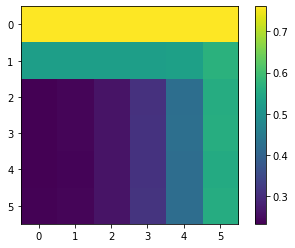

In [63]:
list_max_depth = [2, 6, 18, 56, 168, 504]
list_min_samples_leaf = [1, 3, 9, 27, 81, 243]
res = []
for max_depth in list_max_depth:
    res.append([])
    for min_samples_leaf in list_min_samples_leaf:
        print(' '*100, end = '\r')
        print(str(max_depth) + '\t' + str(min_samples_leaf), end = '\r')
        rf = RandomForestRegressor(max_depth = max_depth, min_samples_leaf = min_samples_leaf)
        rf.fit(train[features], train[target])
        predictions = rf.predict(test[features])
        rmse = np.sqrt(mean_squared_error(predictions, test[target]))
        relat_rmse = rmse / test[target].std()
        res[-1].append(relat_rmse)
print()
        
display(pd.DataFrame(res, columns=list_min_samples_leaf, index=list_max_depth))

plt.imshow(res)
plt.colorbar()
plt.show()

The best parameters have a low value for `min_samples_leaf` and a relatively high value for `max_depth`. 
The performance is thenclose to the default one.

Let us also try to change the number of estimators:

900                                                                                                 


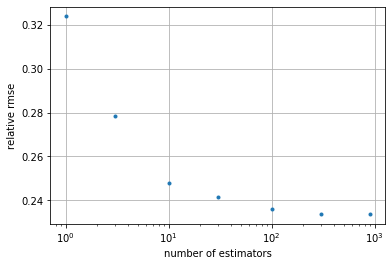

In [65]:
list_n_estimators = [1, 3, 10, 30, 100, 300, 900]
res = []

for n_estimators in list_n_estimators:
    print(' '*100, end = '\r')
    print(str(n_estimators), end = '\r')
    rf = RandomForestRegressor(n_estimators = n_estimators)
    rf.fit(train[features], train[target])
    predictions = rf.predict(test[features])
    rmse = np.sqrt(mean_squared_error(predictions, test[target]))
    relat_rmse = rmse / test[target].std()
    res.append(relat_rmse)
print()

plt.semilogx(list_n_estimators, res, r'.')
plt.xlabel('number of estimators')
plt.ylabel('relative rmse')
plt.grid()
plt.show()

The error seems to decrease with the number of estimators increases, before becoming nearly constant when there are more than 300 of them. 

Let us compute the error and correlation coefficient with 100 estimators:

In [66]:
features = ['temp', 'hr', 'time_label', 'hum', 'yr', 'season', 'weathersit', 'mnth', 'windspeed', 'holiday', 'workingday', 'weekday']

rf5 = RandomForestRegressor(n_estimators = 300)
rf5.fit(train[features], train[target])

predictions = rf5.predict(test[features])
rmse = np.sqrt(mean_squared_error(predictions, test[target]))
relat_rmse = rmse / test[target].std()

print('rmse / std = ' + str(relat_rmse))
print('Correlation coefficient: ' + str(test[target].reset_index(drop=True).corr(pd.Series(predictions))))

rmse / std = 0.23489673285685309
Correlation coefficient: 0.9720309839927382


These results are similar to those obtained with the default value (100).

## Conclusions

In this pproject, we trained a few simple machine learning models to predic the number of bikes rented per hour depending on weather conditions, the date, and the time. 
We found that **a random forest performs significantly better than a linear regressor and slightly better than a single decision tree**. 
This is especialy true when using all the features to train the model. 
We found the minimum error is obtained with 100 or more estimators. 
The root mean squared error is then smaller than 25% of the validation data's standard deviation, and the correlation coefficient between the prediction and data is higher than 97%.

<font style="color:rgb(0,100,200)"><b>To do: <ul>
    <li> predict the casual column </li>
    <li> predict the registered column </li>
</ul></b></font>